# Imports and Setup

In [41]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

# Display config
pd.set_option("display.max_colwidth", 200)
sns.set(style="whitegrid")

# Load Reduced Embeddings

In [43]:
X_reduced = pd.read_csv("../data/tfidf_reduced_50d.csv", index_col=0)

# Confirm shape and structure
print("Shape:", X_reduced.shape)
X_reduced.head()


Shape: (100, 50)


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
ticket_id,,,,,,,,,,,,,,,,,,,,,
1,0.243779,0.273094,0.149473,-0.012156,-0.115746,0.138346,-0.024962,-0.096272,-0.168209,-0.443212,...,-0.119166,0.337365,-0.042570,0.039069,-0.157592,0.010113,-0.077219,0.021770,0.080656,-0.186346
2,0.193443,0.089042,0.179695,0.157146,-0.034550,0.077005,0.138407,0.137993,0.125594,-0.124136,...,-0.087803,-0.041102,0.089848,-0.025135,-0.118590,0.138714,-0.038822,0.050445,-0.146839,0.164341
3,0.126060,-0.012649,-0.035864,-0.176460,0.282824,0.338323,-0.214851,0.305194,0.144680,-0.000488,...,-0.015730,0.052449,-0.019030,-0.042481,-0.015113,-0.068259,-0.063775,0.046489,0.032481,-0.057465
4,0.148116,0.265179,-0.299046,0.050453,-0.039749,0.062044,0.298138,0.044194,0.084804,-0.090762,...,0.044112,-0.099465,0.105082,0.124811,-0.015589,-0.085613,0.028064,-0.033012,-0.016265,-0.091042
5,0.301552,0.208519,0.302274,0.081936,-0.000430,0.104206,-0.066014,0.001119,0.056624,-0.182695,...,0.158063,-0.187489,-0.111741,0.117479,0.067330,-0.010861,0.129901,-0.075285,0.039287,-0.005199


# KMeans Elbow Method

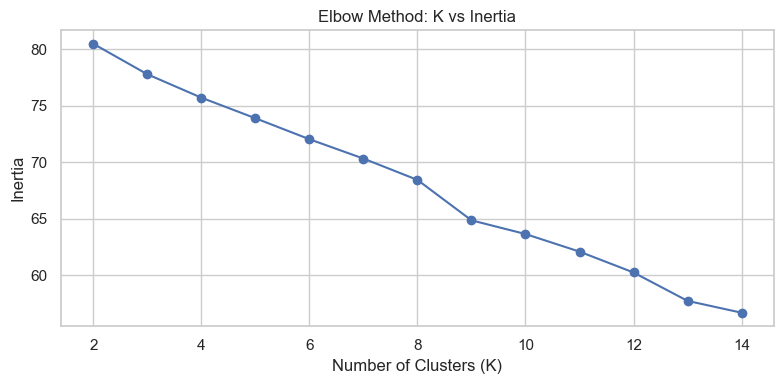

In [44]:
from sklearn.cluster import KMeans

inertias = []
K_range = range(2, 15)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_reduced)
    inertias.append(km.inertia_)

# Plot
plt.figure(figsize=(8, 4))
plt.plot(K_range, inertias, marker='o')
plt.title("Elbow Method: K vs Inertia")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.tight_layout()
plt.show()

In [45]:
k = 10
kmeans = KMeans(n_clusters=k, random_state=42)
labels_kmeans = kmeans.fit_predict(X_reduced)

# Add labels to DataFrame
X_reduced["kmeans_cluster"] = labels_kmeans

# Preview cluster assignments
X_reduced["kmeans_cluster"].value_counts().sort_index()

kmeans_cluster
0     5
1     5
2    11
3     6
4    10
5    11
6    11
7     6
8    30
9     5
Name: count, dtype: int64

## Evaluate KMneans Clustering

In [46]:
from sklearn.metrics import silhouette_score

score = silhouette_score(X_reduced.drop(columns="kmeans_cluster"), labels_kmeans)
print(f"Silhouette Score (KMeans, k=10): {score:.4f}")

Silhouette Score (KMeans, k=10): 0.0638


# HDBSCAN

In [47]:
import hdbscan

# Initialize model — you can tune min_cluster_size
hdb = hdbscan.HDBSCAN(min_cluster_size=2, prediction_data=True)
labels_hdb = hdb.fit_predict(X_reduced.drop(columns="kmeans_cluster"))

# Add HDBSCAN cluster labels (label -1 = noise)
X_reduced["hdbscan_cluster"] = labels_hdb

# Show counts
X_reduced["hdbscan_cluster"].value_counts().sort_index()

hdbscan_cluster
-1     65
 0      3
 1      2
 2      2
 3      3
 4      8
 5      3
 6      4
 7      3
 8      2
 9      2
 10     3
Name: count, dtype: int64

## Inspect sample tickets from clusters

In [48]:
# Load original preprocessed text
df = pd.read_csv("../data/tickets_preprocessed.csv", index_col="ticket_id")

# Merge HDBSCAN cluster labels
df["hdbscan_cluster"] = X_reduced["hdbscan_cluster"]

# Group by cluster and show a few examples from each
for cluster_id in sorted(df["hdbscan_cluster"].unique()):
    print(f"\n--- Cluster {cluster_id} ---")
    display(df[df["hdbscan_cluster"] == cluster_id][["description", "processed_text"]].head(5))



--- Cluster -1 ---


,description,processed_text
ticket_id,,
1,VPN disconnects randomly during video calls. It started after the last system update.,vpn disconnect randomly video call start last system update
2,My laptop battery dies within 30 minutes even after a full charge.,laptop battery dy within minute even full charge
4,Wi-Fi drops every time I join a Teams meeting.,wifi drop every time join team meeting
5,Laptop won’t connect to the company network. Tried restarting and updating drivers.,laptop connect company network try restart update driver
6,Teams notifications don’t show up on my desktop until hours later.,team notification show desktop hour later



--- Cluster 0 ---


,description,processed_text
ticket_id,,
54,CRAC unit 2 is making a high-pitched whine. Could be a fan issue.,crac unit make highpitched whine could fan
66,Blower fan in CRAC unit 1 is showing inconsistent RPMs.,blower fan crac unit show inconsistent rpm
90,CRAC unit maintenance reminder overdue. Unit hasn't been serviced since Q2.,crac unit maintenance reminder overdue unit service since q



--- Cluster 1 ---


,description,processed_text
ticket_id,,
12,The mouse pointer lags significantly when connected to a second monitor.,mouse pointer lag significantly connect second monitor
37,Second monitor not detected until I replug it every time.,second monitor detect replug every time



--- Cluster 2 ---


,description,processed_text
ticket_id,,
95,System showing phantom power draw on circuit B.,system show phantom power draw circuit b
99,Blade server in rack 10A has dim power LED and doesn’t POST.,blade server rack dim power lead post



--- Cluster 3 ---


,description,processed_text
ticket_id,,
75,No temperature readings from cold aisle 5. Might be a disconnected probe.,temperature reading cold aisle might disconnect probe
89,Power cabling to rack 9C is routed across cold aisle incorrectly.,power cable rack c rout across cold aisle incorrectly
97,Dehumidifier in cold aisle 8 is cycling too frequently.,dehumidifier cold aisle cycling frequently



--- Cluster 4 ---


,description,processed_text
ticket_id,,
3,Outlook keeps freezing when I try to search for emails.,outlook keep freeze try search email
7,Unable to install Zoom due to admin restrictions.,unable install zoom due admin restriction
19,Need assistance setting up my dual-monitor workspace.,need assistance set dualmonitor workspace
23,Outlook flags safe emails as junk. I need rules reviewed.,outlook flag safe email junk need rule review
38,Need to install Adobe Acrobat Pro. Install fails silently.,need install adobe acrobat pro install fail silently



--- Cluster 5 ---


,description,processed_text
ticket_id,,
78,Broken LCD panel on the door of cabinet 12A.,broken lcd panel door cabinet
82,PDU outlet is stuck in off state despite control signal being sent.,pdu outlet stick state despite control signal sent
92,Cabinet door sensor not registering open/close state correctly.,cabinet door sensor register openclose state correctly



--- Cluster 6 ---


,description,processed_text
ticket_id,,
8,My external keyboard stopped working after plugging into the docking station.,external keyboard stop work plug dock station
24,"My webcam won’t work in Teams, but works fine in other apps.",webcam work team work fine apps
28,Can’t access company VPN on mobile but works fine on desktop.,access company vpn mobile work fine desktop
42,Teams background blur isn’t working anymore. Reinstall didn’t help.,team background blur work anymore reinstall



--- Cluster 7 ---


,description,processed_text
ticket_id,,
10,System is extremely slow after the last antivirus update.,system extremely slow last antivirus update
17,Software update failed and now the laptop boots to a recovery screen.,software update fail laptop boot recovery screen
84,SNMP polling timeout on firewall 2 after policy update.,snmp poll timeout firewall policy update



--- Cluster 8 ---


,description,processed_text
ticket_id,,
63,Server in rack 6B failed firmware update and won't boot.,server rack b fail firmware update boot
88,Switch firmware is out-of-date and failing compliance checks.,switch firmware outofdate fail compliance check



--- Cluster 9 ---


,description,processed_text
ticket_id,,
41,Outlook calendar fails to send invites intermittently.,outlook calendar fail send invite intermittently
46,The trackpad skips around and ignores inputs sometimes.,trackpad skip around ignores input sometimes



--- Cluster 10 ---


,description,processed_text
ticket_id,,
25,Frequent blue screens since last Windows update. Happens during Zoom.,frequent blue screen since last window update happens zoom
30,Every restart brings up the 'Preparing Windows' screen for 5+ minutes.,every restart bring prepare window screen minute
45,"After Windows lock screen, all apps re-open resized.",window lock screen apps reopen resize


## UMAP Visualization

c:\Users\Scott\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


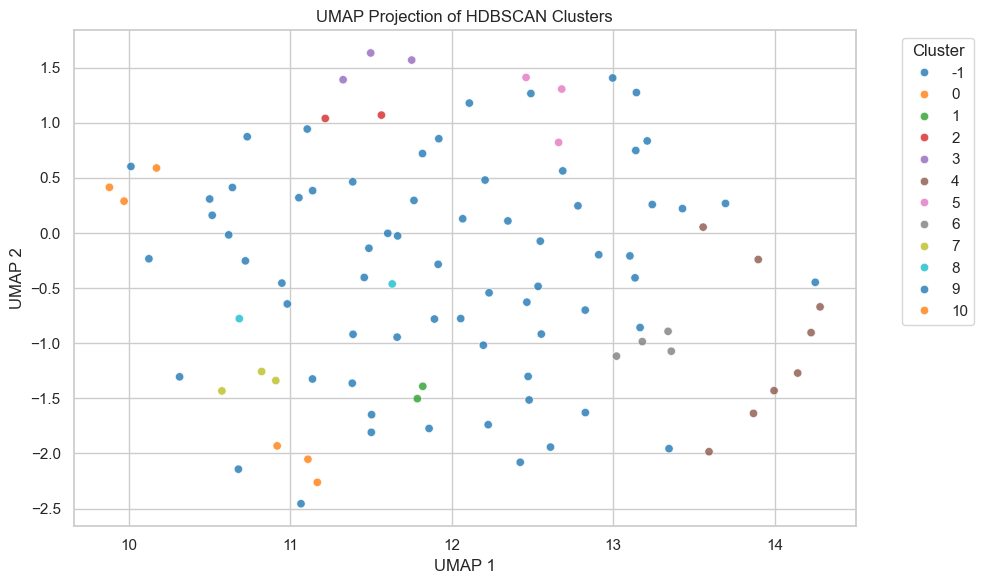

In [49]:
import umap.umap_ as umap
import matplotlib.pyplot as plt

# Reduce to 2D for visualization
umap_model = umap.UMAP(random_state=42)
X_umap = umap_model.fit_transform(X_reduced.drop(columns=["kmeans_cluster", "hdbscan_cluster"]))

# Add coordinates back to the DataFrame
X_reduced["umap_x"] = X_umap[:, 0]
X_reduced["umap_y"] = X_umap[:, 1]

# Save UMAP coordinates and cluster labels to new CSV
X_reduced[["umap_x", "umap_y", "hdbscan_cluster"]].to_csv("../data/umap_projection.csv")

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=X_reduced,
    x="umap_x", y="umap_y",
    hue="hdbscan_cluster",
    palette="tab10",
    legend="full",
    alpha=0.8
)
plt.title("UMAP Projection of HDBSCAN Clusters")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## Summarize Each Cluster

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Reload preprocessed text and cluster labels
df = pd.read_csv("../data/tickets_preprocessed.csv", index_col="ticket_id")
df["hdbscan_cluster"] = X_reduced["hdbscan_cluster"]

# Use the same TF-IDF vectorizer (you can load from joblib if needed)
vectorizer = TfidfVectorizer(stop_words="english", max_df=0.95, min_df=2)
tfidf_matrix = vectorizer.fit_transform(df["processed_text"])
terms = vectorizer.get_feature_names_out()

# Summarize each cluster
for cluster_id in sorted(df["hdbscan_cluster"].unique()):
    if cluster_id == -1:
        continue  # Skip noise
    indices = df[df["hdbscan_cluster"] == cluster_id].index
    cluster_tfidf = tfidf_matrix[[i - 1 for i in indices]]  # adjust for ticket_id index
    mean_tfidf = np.asarray(cluster_tfidf.mean(axis=0)).flatten()
    top_indices = mean_tfidf.argsort()[::-1][:10]
    keywords = [terms[i] for i in top_indices]
    
    print(f"\n--- Cluster {cluster_id}: Top Keywords ---")
    print(", ".join(keywords))


--- Cluster 0: Top Keywords ---
unit, crac, fan, blower, maintenance, zoom, install, fail, false, fine

--- Cluster 1: Top Keywords ---
second, monitor, time, detect, mouse, lag, connect, flicker, high, generator

--- Cluster 2: Top Keywords ---
power, draw, rack, server, zoom, error, fail, false, fan, fine

--- Cluster 3: Top Keywords ---
cold, aisle, temperature, disconnect, cable, power, rack, zoom, hour, high

--- Cluster 4: Top Keywords ---
need, install, zone, email, outlook, admin, zoom, rule, search, airflow

--- Cluster 5: Top Keywords ---
state, door, cabinet, pdu, panel, sensor, zoom, high, generator, firmware

--- Cluster 6: Top Keywords ---
work, team, fine, apps, mobile, desktop, company, vpn, access, loud

--- Cluster 7: Top Keywords ---
update, policy, boot, laptop, screen, fail, event, false, fan, fine

--- Cluster 8: Top Keywords ---
firmware, fail, switch, boot, update, rack, server, zoom, hour, event

--- Cluster 9: Top Keywords ---
calendar, outlook, fail, zoom, f

# Export HDBSCAN Clusters and Summary Keywords

In [51]:
# Merge with original descriptions
df_full = df[["description", "processed_text", "hdbscan_cluster"]]
df_full.to_csv("../data/ticket_clusters_hdbscan.csv")

print("Saved ticket_clusters_hdbscan.csv")

Saved ticket_clusters_hdbscan.csv


In [52]:
# Cell 10B: Save top keywords per cluster

cluster_keywords = []

for cluster_id in sorted(df["hdbscan_cluster"].unique()):
    if cluster_id == -1:
        continue
    indices = df[df["hdbscan_cluster"] == cluster_id].index
    cluster_tfidf = tfidf_matrix[[i - 1 for i in indices]]
    mean_tfidf = np.asarray(cluster_tfidf.mean(axis=0)).flatten()
    top_indices = mean_tfidf.argsort()[::-1][:10]
    keywords = [terms[i] for i in top_indices]
    cluster_keywords.append({
        "cluster": cluster_id,
        "keywords": ", ".join(keywords)
    })

# Save to CSV
keywords_df = pd.DataFrame(cluster_keywords)
keywords_df.to_csv("../data/cluster_keywords_hdbscan.csv", index=False)

print("Saved cluster_keywords_hdbscan.csv")


Saved cluster_keywords_hdbscan.csv
